In [1]:
%load_ext autoreload
%autoreload 2

# Short Text Clustering using CNN

The following work is mainly inspired by:
- 2014 - Convolutional Neural Networks for Sentence Classification
- 2014 - A Convolutional Neural Network for Modelling Sentences
- 2017 - Self-Taught Convolutional Neural Networks for Short Text Clustering

<br>
Word embedding from fasttext are distributed under the license:
- Creative Commons Attribution-Share-Alike License 3.0 (free commercial use)

#### Load modules

In [2]:
import os
import numpy as np
import pandas as pd
from pprint import pprint
from tqdm import tqdm_notebook
from webcolors import name_to_rgb
from matplotlib import pyplot as plt

# scikit-learn
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer, normalize
from sklearn.feature_extraction.text import TfidfVectorizer

# keras
from keras.models import Model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding

# self-made function
from utils.target import laplacian_eigenmaps, binarize
from utils.metrics import map_label, cluster_quality
from utils.cnn import create_reference_model, behead
from utils.embedding import Embeddor
from utils.variable import COLOR_NAMES

%matplotlib inline

Using TensorFlow backend.


In [3]:
EMBDIR = "./embeddings/"
DATADIR = "./data/short_texts/"

print('\nShort text datasets')
pprint(os.listdir(DATADIR))

print('\nEmbedding')
pprint(os.listdir(EMBDIR))


Short text datasets
['Biomedical.txt',
 'Biomedical_gnd.txt',
 'SearchSnippets.txt',
 'SearchSnippets_gnd.txt',
 'StackOverflow.txt',
 'StackOverflow_gnd.txt']

Embedding
['glove100K.100d.vec']


# Fetching the data

#### Loading pre-trained Fasttext word embedding

Pre-trained word vectors for English languages, trained on Wikipedia using fastText. These vectors of dimension `300` were obtained using the skip-gram model described in `Bojanowski et al.(2016)` with default parameters.

We extracted the `100 000` most frequent words.

# Word embedding

In [4]:
# parameters
n_emb = int(1 * 1e5)
# emb_name = 'fasttext.wiki.en.vec'
emb_name = 'glove100k.100d.vec'
print("Embedding: %s" % emb_name)
src_emb = os.path.join(EMBDIR, emb_name)

# embeddor
embeddor = Embeddor(notebook_display=True)
emb_mat = embeddor.load_emb(src_emb, n_emb)
print("Embedding shape: {}".format(emb_mat.shape))

Embedding: glove100k.100d.vec



Embedding shape: (100001, 100)


In [5]:
embeddor.most_similar('napoleon')

[('napoleon', 0.99999976),
 ('bonaparte', 0.87043333),
 ('napoléon', 0.66390216),
 ('napoleonic', 0.65167707),
 ('augustus', 0.64356035),
 ('caesar', 0.64281428),
 ('1812', 0.63069737),
 ('tsar', 0.6110847),
 ('xiv', 0.61083198),
 ('emperor', 0.60819435)]

# Load text data

#### Loading data

In [6]:
#DATA = "Biomedical"
#DATA = "SearchSnippets"
DATA = "StackOverflow"

text_path = os.path.join(DATADIR, '%s.txt' % DATA)
with open(text_path, encoding="utf-8") as f:
    data = f.readlines()

label_path = os.path.join(DATADIR, '%s_gnd.txt' % DATA)
with open(label_path, encoding="utf-8") as f:
    target = f.readlines()
target = [int(label.rstrip('\n')) for label in target]
    
print("Total: %s short texts" % format(len(data), ","))

Total: 20,000 short texts


#### Random samples

In [7]:
n = len(data)
sample = 5000
print("Loading %s samples" % format(sample, ","))
index_sample = np.random.randint(0, n, sample)

data = [data[idx] for idx in index_sample]
target = [target[idx] for idx in index_sample]

Loading 5,000 samples


#### Tokenize

In [8]:

tokenizer = Tokenizer(char_level=False)
tokenizer.fit_on_texts(data)
sequences_full = tokenizer.texts_to_sequences(data)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
MAX_NB_WORDS = len(word_index)

seq_lens = [len(s) for s in sequences_full]
print("Average length: %d" % np.mean(seq_lens))
print("Max length: %d" % max(seq_lens))
MAX_SEQUENCE_LENGTH = max(seq_lens)

X = pad_sequences(sequences_full, maxlen=MAX_SEQUENCE_LENGTH)
y = target
tfidf = tokenizer.sequences_to_matrix(sequences_full, mode='tfidf')

Found 5161 unique tokens.
Average length: 8
Max length: 34


# Getting sequences and targets

In [9]:
# creating embedding matrix
EMBEDDING_DIM = embeddor.emb_dim
N_CLASSES = 21

# prepare embedding matrix
nb_words_in_matrix = 0
nb_words = min(MAX_NB_WORDS, len(word_index))
embedding_matrix = np.zeros((nb_words + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding = embeddor.get_emb(word)
    if embedding is not None:
        embedding_matrix[i] = embedding
        nb_words_in_matrix = nb_words_in_matrix + 1
        
print("added %d words in the embedding matrix" % nb_words_in_matrix)

added 3499 words in the embedding matrix


# Target vectors 

In [10]:
# dictionary containing all target vectors
Y = dict()

# dicitonary containing all binarized vectors
B = dict()

#### Average embeddings (AE)

In [11]:
%%time
denom = 1 + np.sum(tfidf, axis=1)[:, None]
normed_tfidf = tfidf/denom
average_embeddings = np.dot(normed_tfidf, embedding_matrix)
Y['ae'] = average_embeddings
B['ae'] = binarize(Y['ae'])
print("Shape of average embedding: ", Y['ae'].shape)

Shape of average embedding:  (5000, 100)
CPU times: user 607 ms, sys: 279 ms, total: 886 ms
Wall time: 888 ms


#### Latent Semantic Analysis (LSA)

In [12]:
%%time
lsa = make_pipeline(
    TruncatedSVD(100),
    Normalizer(copy=False),
) 
lsa_vectors = lsa.fit_transform(tfidf)
Y['lsa'] = lsa_vectors
B['lsa'] = binarize(Y['lsa'])
print("Shape of latent semantic vectors: ", Y['lsa'].shape)

Shape of latent semantic vectors:  (5000, 100)
CPU times: user 4.33 s, sys: 371 ms, total: 4.7 s
Wall time: 2.95 s


#### Laplacian Eigenmaps (LE) [memory intensive]

In [13]:
%%time
laplacian_vectors = laplacian_eigenmaps(lsa_vectors, n_neighbors=15, subdim=15, n_jobs=-1)
Y['le'] = laplacian_vectors
B['le'] = binarize(Y['le'])
print(Y['le'].shape)

Fitting nearest neighbors
Creation of heat kernel affinity matrix
Spectral embedding
(5000, 15)
CPU times: user 27.5 s, sys: 2.26 s, total: 29.7 s
Wall time: 18.3 s


# CNN for deep feature learning 

#### Embedding layer

In [14]:
embedding_matrix_copy = embedding_matrix.copy()

# Embedding layer
pretrained_embedding_layer = Embedding(
    input_dim=MAX_NB_WORDS+1,
    output_dim=EMBEDDING_DIM,
    weights=[embedding_matrix],
    input_length=MAX_SEQUENCE_LENGTH,
)

#### Deep feature learning

In [18]:
nb_epoch = 2 
D = dict()
for method in ['lsa', 'ae', 'le']:
    print("Method: {}".format(method))
    cnn_model = create_reference_model(
        input_dim=MAX_SEQUENCE_LENGTH,
        output_dim=B[method].shape[1],
        embedding_layer=pretrained_embedding_layer,
    )

    cnn_model.fit(X, B[method], validation_split=0.2, epochs=nb_epoch, batch_size=100, verbose=2)

    beheaded_cnn = behead(cnn_model)
    D[method] = beheaded_cnn.predict(X)
    print("Sample shape: {}".format(D[method].shape))
    print()

Method: lsa
Train on 4000 samples, validate on 1000 samples
Epoch 1/2
3s - loss: 0.6909 - mean_absolute_error: 0.4976 - val_loss: 0.6860 - val_mean_absolute_error: 0.4955
Epoch 2/2
2s - loss: 0.6849 - mean_absolute_error: 0.4937 - val_loss: 0.6816 - val_mean_absolute_error: 0.4925
Sample shape: (5000, 100)

Method: ae
Train on 4000 samples, validate on 1000 samples
Epoch 1/2
3s - loss: 0.6126 - mean_absolute_error: 0.4386 - val_loss: 0.5244 - val_mean_absolute_error: 0.3592
Epoch 2/2
3s - loss: 0.5272 - mean_absolute_error: 0.3511 - val_loss: 0.5059 - val_mean_absolute_error: 0.3460
Sample shape: (5000, 100)

Method: le
Train on 4000 samples, validate on 1000 samples
Epoch 1/2
3s - loss: 0.6738 - mean_absolute_error: 0.4829 - val_loss: 0.6588 - val_mean_absolute_error: 0.4737
Epoch 2/2
3s - loss: 0.6504 - mean_absolute_error: 0.4681 - val_loss: 0.6372 - val_mean_absolute_error: 0.4626
Sample shape: (5000, 100)



# Tools for evaluating cluster quality

## K-means 

In [19]:
true_labels = y
n_clusters = len(np.unique(y))
print("Number of classes: %d" % n_clusters)
km = KMeans(n_clusters=n_clusters, n_jobs=-1)
result = dict()
pred = dict()

Number of classes: 20


#### Deep feature from Average Embedding

In [20]:
method = 'ae'
deep_features = normalize(D[method], norm='l2')
print('Shape: {}'.format(deep_features.shape)) 
km.fit(deep_features)
y_pred = km.labels_
result['deep_ae'] = cluster_quality(true_labels, y_pred)
pred['deep_ae'] = y_pred

Shape: (5000, 100)
Homogeneity: 0.061
Completeness: 0.069
V-measure: 0.065
NMI: 0.065
Rand score: 0.012
Accuracy: 0.126


#### Deep feature from LSA

In [21]:
method = 'lsa'
deep_features = normalize(D[method], norm='l2')
print('Shape: {}'.format(deep_features.shape)) 
km.fit(deep_features)
y_pred = km.labels_
result['deep_lsa'] = cluster_quality(true_labels, y_pred)
pred['deep_lsa'] = y_pred

Shape: (5000, 100)
Homogeneity: 0.343
Completeness: 0.372
V-measure: 0.357
NMI: 0.357
Rand score: 0.166
Accuracy: 0.396


#### Deep feature from Laplacian Eigenvalues

In [22]:
method = 'le'
deep_features = normalize(D[method], norm='l2')
print('Shape: {}'.format(deep_features.shape)) 
km.fit(deep_features)
y_pred = km.labels_
result['deep_le'] = cluster_quality(true_labels, y_pred)
pred['deep_le'] = y_pred

Shape: (5000, 100)
Homogeneity: 0.445
Completeness: 0.466
V-measure: 0.455
NMI: 0.455
Rand score: 0.275
Accuracy: 0.494


#### LSA

In [23]:
lsa_features = Y['lsa']
print('Shape: {}'.format(lsa_features.shape)) 
km.fit(lsa_features)
y_pred = km.labels_
result['lsa'] = cluster_quality(true_labels, y_pred)
pred['lsa'] = y_pred

Shape: (5000, 100)
Homogeneity: 0.657
Completeness: 0.706
V-measure: 0.681
NMI: 0.682
Rand score: 0.388
Accuracy: 0.704


#### Laplacian Eigenvalues aka Spectral clustering 

In [24]:
laplacian_features = normalize(Y['le'], norm='l2')
print('Shape: {}'.format(laplacian_features.shape)) 
km.fit(laplacian_features)
y_pred = km.labels_
result['le'] = cluster_quality(true_labels, y_pred)
pred['le'] = y_pred

Shape: (5000, 15)
Homogeneity: 0.539
Completeness: 0.546
V-measure: 0.543
NMI: 0.543
Rand score: 0.465
Accuracy: 0.674


# Cluster visualization

In [25]:
# random sample because t-sne is slow
tsne_sample = 1000
index_sample = np.random.randint(low=0, high=sample, size=(tsne_sample,))

# mapping color to sample
labels = np.unique(y)
colormap = {label: color for label, color in zip(labels, COLOR_NAMES)}
colors = [colormap[x] for x in true_labels]
color_rgb = [name_to_rgb(name) for name in colors]
color_rgb_norm = [(x/255., y/255., z/255.) for x, y, z in color_rgb]
color_sample = [color_rgb_norm[idx] for idx in index_sample]

# plot function
def plot_tsne(T, color):
    plt.figure(figsize=(10, 10))
    plt.scatter(T[:, 0], T[:, 1], c=color, s=30)

## t-SNE 

<br>
Remarks:
- Using Laplacian Eigenvalues, we obtain very dense clusters
- Using LSA as target, results are also quite good
- LSA is very competitive for accuracy

In [26]:
# T-SNE model
tsne = TSNE(n_components=2, 
            perplexity=30, 
            early_exaggeration=4.,
            learning_rate=1000,
            init="pca", 
            metric="euclidean")

#### Deep feature representation from Laplacian Eigenvalues

In [27]:
%%time
rand_deep_features = deep_features[index_sample]
tsne_deep = tsne.fit_transform(rand_deep_features)

CPU times: user 29.9 s, sys: 2.86 s, total: 32.8 s
Wall time: 33.4 s


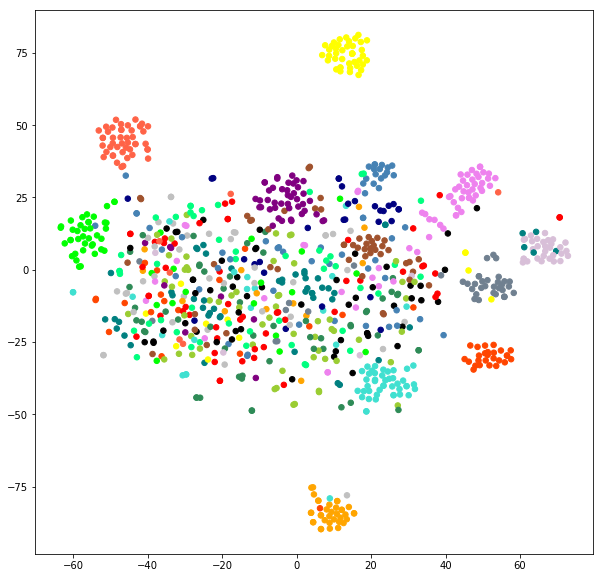

In [28]:
plot_tsne(tsne_deep, color=color_sample)

####  LSA

In [29]:
%%time
tsne_lsa = tsne.fit_transform(lsa_features[index_sample])

CPU times: user 27.6 s, sys: 3.61 s, total: 31.3 s
Wall time: 33.9 s


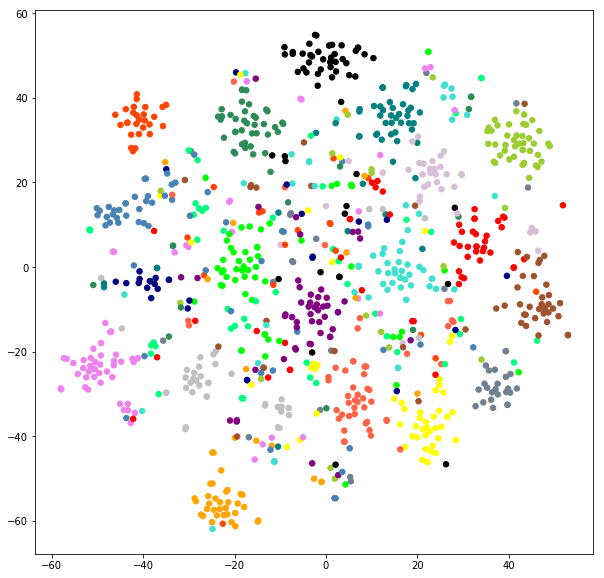

In [30]:
# matplotlib visualization
plot_tsne(tsne_lsa, color=color_sample)

#### Laplacian eigenvalues

In [31]:
%%time
tsne_laplacian = tsne.fit_transform(laplacian_features[index_sample])

CPU times: user 24.8 s, sys: 3.61 s, total: 28.4 s
Wall time: 32.7 s


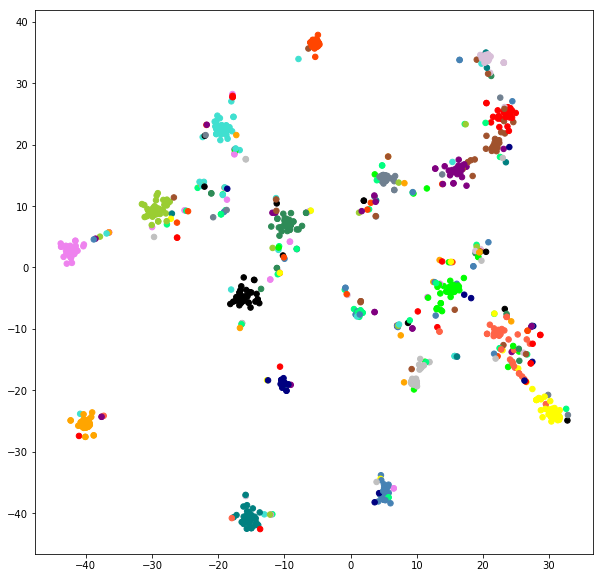

In [32]:
plot_tsne(tsne_laplacian, color=color_sample)